## Homework 5 Dimensionality Reduction and Clustering
### Matt Oehler
___

In [2]:
#import libraries and datasets
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### Problem 1:
Here we'll perform some PCA on the MNIST Dataset

In [3]:
#load MNIST dataset
mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0 #dividing by 255 scales the data for us, but doesn't center it
y = mnist.target

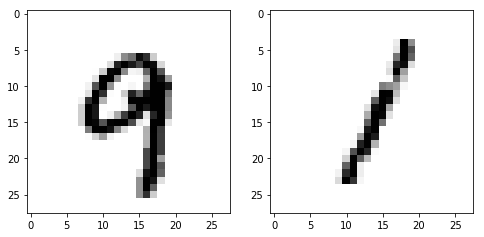

In [72]:
#preview images
plt.figure(figsize=(8,4));
plt.subplot(1, 2, 1);
plt.imshow(X[55555].reshape(28,28), cmap=plt.get_cmap('Greys'))

plt.subplot(1, 2, 2);
plt.imshow(X[12345].reshape(28,28), cmap=plt.get_cmap('Greys'))
plt.show()

## 1. Use PCA to reduce the dimensionality

PCA requires that the data are centered. For visualization's sake I chose to plot an image after centering it using Sklearn's StandardScaler class.

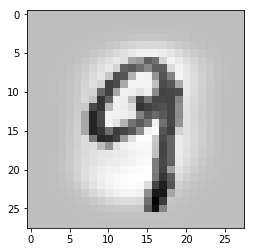

In [59]:
# scale data and plot a sample scaled image
X_scaled = StandardScaler(with_std=False).fit_transform(X)
plt.imshow(X_scaled[55555].reshape(28,28), cmap=plt.get_cmap('Greys'))
plt.show()

In [63]:
#PCA for MNIST
#note that sklearn does the necessary scaling for us
pca = PCA(n_components=400)
X_pca = pca.fit_transform(X_scaled) #use smaller dataset to save run-time
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

#how many components do we need?
index_95 = np.argmax(cum_ratio >= 0.95)
print("To retain 95% of the variance we need to use at least {} principal components".format(index_95+1))

To retain 95% of the variance we need to use at least 154 principal components


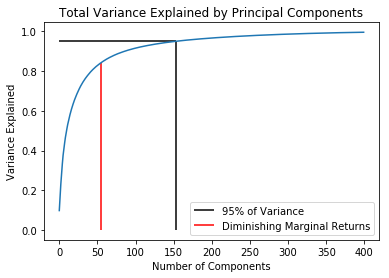

In [64]:
#plot the explained variance ratio
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.title("Total Variance Explained by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.vlines(ymin=0,ymax=cum_ratio[index_95],x=index_95,
           label='95% of Variance')
plt.vlines(ymin=0,ymax=cum_ratio[55],x=55,
           label='Diminishing Marginal Returns',color = 'red')
plt.hlines(xmin=0,y=.95,xmax=index_95) #makes a horizontal line at 95% variance
plt.legend()
plt.show()

a. How many components did you use? Why?
 - I used 154 principal components since that retains 95% of the variance of the original data. However, an argument could be made to use approximately 55 components since that is about where the marginal returns of adding another component seems to diminish significantly.
 

#### Next we'll take a look at the first two components.       
b. Plot the first two components. Do you notice any trends? What is this plot showing us?
 - This plot is showing us that there is more variance along the first component vs the second component, which is what we expect. I don't think there is a neccessarily a major trend, but I do think that there are more points clumped together on the right side than on the left.

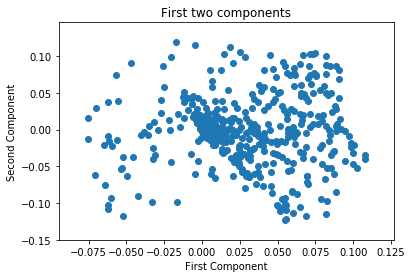

In [67]:
plt.scatter(pca.components_[0],pca.components_[1])
plt.title("First two components")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.show()

c. Why would you use PCA? What is it doing? And what are the drawbacks?
   - PCA is useful in reducing the negative effects of the curse of dimensionality. You can use it to reduce the number of dimensions of your data such that for each dimension you take out, you lose the minimum amount of information contained in the data. (This is done by having each component maximize the amount of variance retained by the data). One of the main drawbacks of PCA is the loss of data/model interpretibility.
    
d. Plot some of the images, then compress them using PCA and plot again. How does it look?
 - since some of the variance of the data is lost when you don't use all of the components, the resulting images are more blurry.
    

Original Images


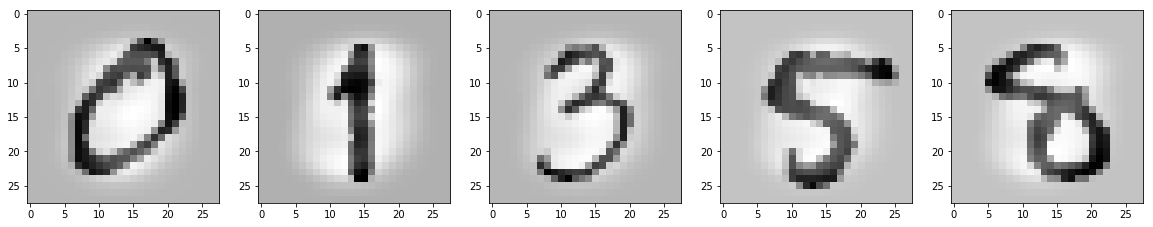

In [85]:
#original images (scaled this time)
print("Original Images")
plt.figure(figsize=(20,4));
plt.subplot(1, 5, 1);
plt.imshow(X_scaled[0].reshape(28,28), cmap=plt.get_cmap('Greys'))

plt.subplot(1, 5, 2);
plt.imshow(X_scaled[11000].reshape(28,28), cmap=plt.get_cmap('Greys'))

plt.subplot(1, 5, 3);
plt.imshow(X_scaled[20000].reshape(28,28), cmap=plt.get_cmap('Greys'))

plt.subplot(1, 5, 4);
plt.imshow(X_scaled[33000].reshape(28,28), cmap=plt.get_cmap('Greys'))

plt.subplot(1, 5, 5);
plt.imshow(X_scaled[50000].reshape(28,28), cmap=plt.get_cmap('Greys'))
plt.show()

In [78]:
#make compressed images
#set up PCA (note that I didn't scale the data in this case)
pca2 = PCA(0.85) #I chose 0.85 to emphasize the fuzziness
lower_dimensional_data = pca2.fit_transform(X)#_scaled)
print("Number of Compenents needed for 85% of the variance:",pca2.n_components_)

approximation = pca2.inverse_transform(lower_dimensional_data)

Number of Compenents needed for 85% of the variance: 59


Images Generated using only 59 principal components


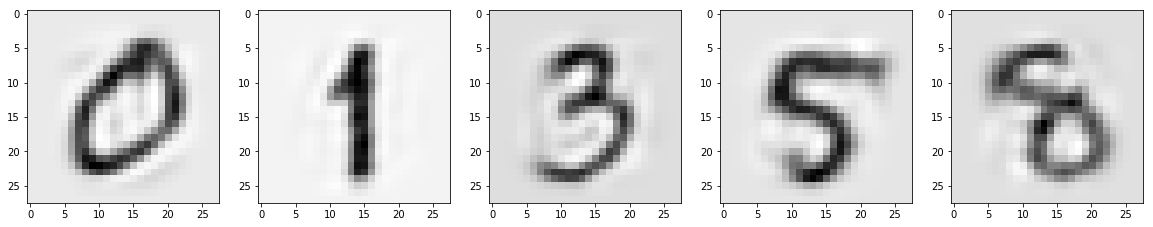

In [88]:
#display compressed image
print("Images Generated using only {} principal components".format(pca2.n_components_))
plt.figure(figsize=(20,4));
plt.subplot(1, 5, 1);
plt.imshow(approximation[0].reshape(28, 28), cmap = plt.get_cmap('Greys'))

plt.subplot(1, 5, 2);
plt.imshow(approximation[11000].reshape(28, 28), cmap = plt.get_cmap('Greys'))

plt.subplot(1, 5, 3);
plt.imshow(approximation[20000].reshape(28, 28), cmap = plt.get_cmap('Greys'))

plt.subplot(1, 5, 4);
plt.imshow(approximation[33000].reshape(28, 28), cmap = plt.get_cmap('Greys'))

plt.subplot(1, 5, 5);
plt.imshow(approximation[50000].reshape(28, 28), cmap = plt.get_cmap('Greys'))
plt.show()

## 2.  t-SNE
Use t-SNE to plot the first two components (you should probably random sample around 10000 points):

a. How does this plot differ from your PCA plot?
- it's different in that you can visualize all of the clusters more easily. 
    
b. How robust is it to changes in perplexity?
- I only did one comparison (because of runtime) using a perplexity of 10, and it seemed to still perform well
    
c. How robust is it to different learning rate and number of iterations?
- for these parameters as well I only did one comparison (250 iterations, and 100 learning rate). The results were quite different with fewer iterations. Using a smaller learning rate (100 instead of 200) I found that...

In [93]:
#Use data reduced by PCA before feeding to t-sne
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.330s...
[t-SNE] Computed neighbors for 10000 samples in 108.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.169145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.637939
[t-SNE] Error after 1000 iterations: 1.734772


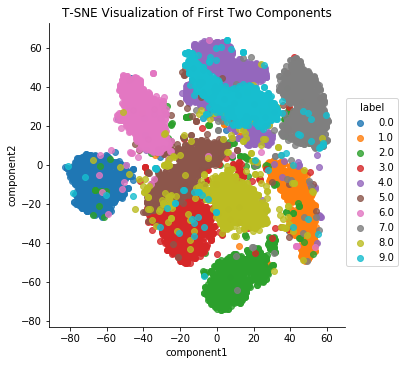

In [94]:
df_tsne = pd.DataFrame(tsne_results, columns=['component1', 'component2'])
df_tsne['label'] = y[rows[:n_select]]
#plot it
sns.lmplot(x='component1', y='component2', data=df_tsne, hue='label', fit_reg=False)
plt.title("T-SNE Visualization of First Two Components")
sns.despine()

In [96]:
#use a different perplexity
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.288s...
[t-SNE] Computed neighbors for 10000 samples in 102.901s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.641880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.228737
[t-SNE] Error after 1000 iterations: 1.953358


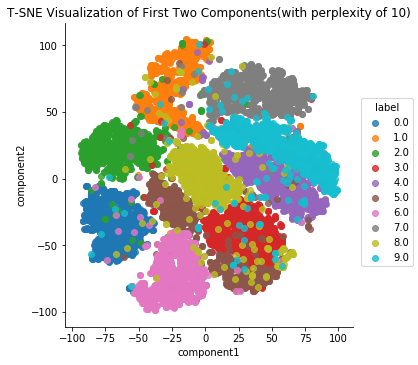

In [97]:
#plot of different perplexity
df_tsne = pd.DataFrame(tsne_results, columns=['component1', 'component2'])
df_tsne['label'] = y[rows[:n_select]]
#plot it
sns.lmplot(x='component1', y='component2', data=df_tsne, hue='label', fit_reg=False)
plt.title("T-SNE Visualization of First Two Components(with perplexity of 10)")
sns.despine()

In [ ]:
#differnet number of iterations
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=250, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#organize results
df_tsne = pd.DataFrame(tsne_results, columns=['component1', 'component2'])
df_tsne['label'] = y[rows[:n_select]]

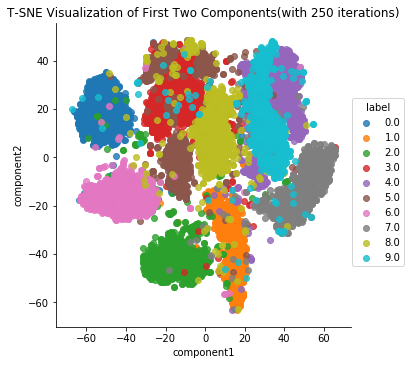

In [101]:
#plot it
sns.lmplot(x='component1', y='component2', data=df_tsne, hue='label', fit_reg=False)
plt.title("T-SNE Visualization of First Two Components(with 250 iterations)")
sns.despine()

In [ ]:
#different learning rate
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=100)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

#organize results
df_tsne = pd.DataFrame(tsne_results, columns=['component1', 'component2'])
df_tsne['label'] = y[rows[:n_select]]

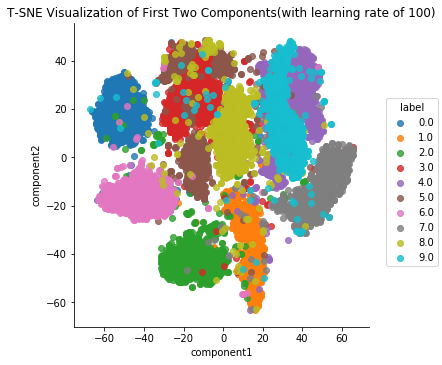

In [102]:
#plot it
sns.lmplot(x='component1', y='component2', data=df_tsne, hue='label', fit_reg=False)
plt.title("T-SNE Visualization of First Two Components(with learning rate of 100)")
sns.despine()

## 3. Perform k-means clustering:

a. How did you choose k?
- We know that there are 10 different digits to classify. This makes it easy to choose K, becuase we want 1 cluster per digit.
    

In [ ]:
X_pca.shape

In [18]:
#make train and test sets
train_img, test_img, train_lbl, test_lbl = train_test_split(X_scaled, y, test_size=1/7.0, random_state=0)

#use 10 clusters and fit with K-means
kmeans = KMeans(n_clusters=10, n_init=25, n_jobs=-1)
kmeans.fit(train_img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=25, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [35]:
#adjusted rand index (needs truth)
pred_labels = kmeans.predict(test_img)
true_labels = test_lbl

ARI = metrics.adjusted_rand_score(true_labels,pred_labels)
print("ARI:", ARI)

#Mutual information based scores
MIBS = metrics.adjusted_mutual_info_score(true_labels, pred_labels)
print("MIBS:", MIBS)

#homogeneity, completeness, and V-measure
homo = metrics.homogeneity_completeness_v_measure(true_labels, pred_labels)
print("Homogeneity, completeness, and V-measure:", np.round(homo,4))

#Fowlkes-Mallows scores (results in a NaN)
# fowlkes = metrics.fowlkes_mallows_score(true_labels, pred_labels)
# print("Fowlkes-Mallows:", fowlkes)



ARI: 0.37010373489020815
MIBS: 0.4909781804358026
Homogeneity, completeness, and V-measure: [0.4919 0.4948 0.4933]
Fowlkes-Mallows: nan


C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: RuntimeWarning: overflow encountered in int_scalars
  return tk / np.sqrt(pk * qk) if tk != 0. else 0.
C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: RuntimeWarning: invalid value encountered in sqrt
  return tk / np.sqrt(pk * qk) if tk != 0. else 0.


    b. How did you evaluate your clustering?
    - I used 4 different metrics to evaluate the my clustering. I specifically chose to use these metrics because they incorporate knowlege of the "ground truth" or in other words, knowlege of the true labels. Since we have access to this, I felt that they would be the best metrics. In an industry setting where we didn't have access to the ground truth then something like the Silhouette Coefficient would be a better metric.
    
    c. Visualize your clusters using t-sne
    - ???
    
    d. Did you scale your data?
    - I chose to scale the data just for the sake of consistency, but I feel that justifiable arguments could be made to not scale the data. Since the pixels are all measures of grayness, we don't have range issues when comparing column to column. Some might also argue that scaling the gray values diminishes there true meaning. I don't fully agree with that and so I feel fine just leaving my data in the scaled format I used from PCA when doing clustering.  
    
    e. How robust is your clustering?
    - The clustering seems to be pretty robust. In general, by increaseing the n_init parameter for K-Means clustering you can increase the robustness of the algorithm. The n_init parameter is the number of times the algorithm will re-do the clustering algorithm with different random starting points. Having a higher number will ensure that your overall results converge to the best clusters.

In [37]:
#visualie results with t-SNE
#for t_SNE we use PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 9000

tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000, learning_rate=200)
tsne_results = tsne.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.031s...
[t-SNE] Computed neighbors for 9000 samples in 11.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 1.918826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.366837
[t-SNE] Error after 1000 iterations: 1.666452


In [40]:
df_tsne = pd.DataFrame(tsne_results, columns=['component1', 'component2'])
# df_tsne['label'] = y[rows[:n_select]]
df_tsne.shape
#this time we use labels from the clustering algorithm
# df_tsne['label'] = kmeans.predict(X_pca[rows[:n_select]])
#plot it
# sns.lmplot(x='component1', y='component2', data=df_tsne, hue='label', fit_reg=False)

(9000, 2)

## Hierarchical Clustering

Here I made three separate dendrograms using different linkage methods. We can see that dendrograms are quire different for each linkage method. I was particularly surprised to see that despite having a relatively odd dendrogram, the 'single' linkage method looks like it performed just as good as the other two linage methods. I didn't think that a simple method would perform similarly.

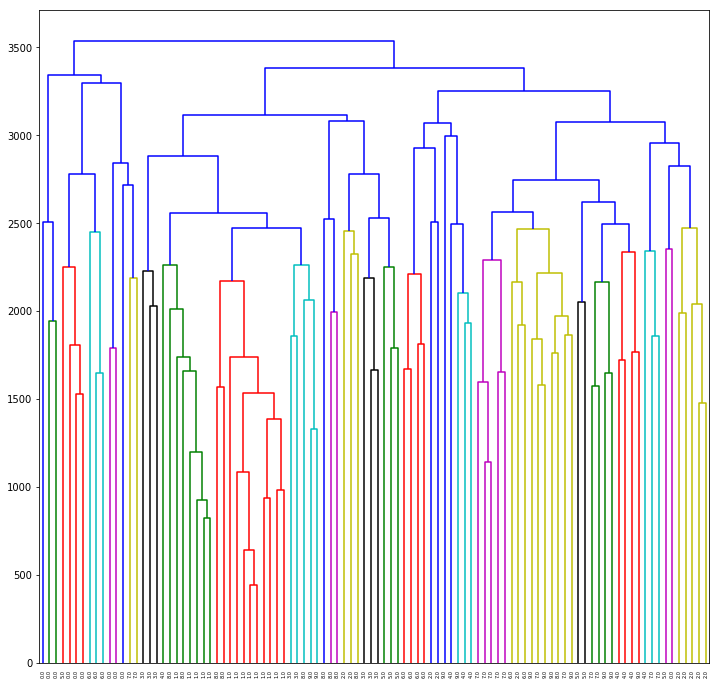

In [66]:
rows = np.arange(60000)
np.random.shuffle(rows)
n_select = 100
Z = linkage(train_img[rows[:n_select]], 'complete')
plt.figure(figsize=(22, 15))
_ = dendrogram(Z,labels = train_lbl[rows[:n_select]].astype('int'),leaf_font_size = 12)
# print(train_lbl[rows[:n_select]])

Based on the above dendrogram (which is only based on 100 images), if we make the cut off point at approximately 3000 on the y-axis (which seems like a reasonable cutting point, we would end up with 10 clusters.

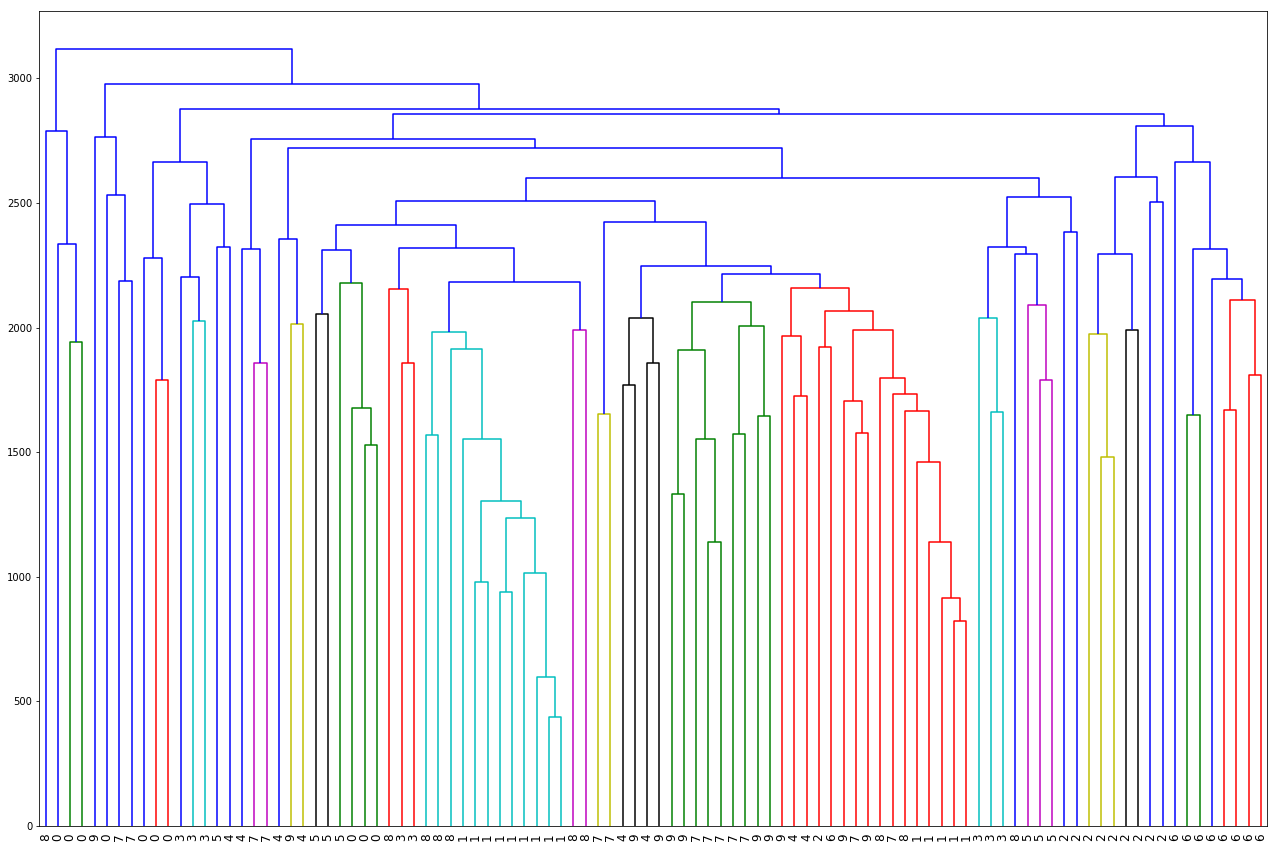

In [82]:
Z = linkage(train_img[rows[:n_select]], 'weighted')
plt.figure(figsize=(22, 15))
_ = dendrogram(Z,labels = train_lbl[rows[:n_select]].astype('int'),leaf_font_size = 12)
# print(train_lbl[rows[:n_select]])

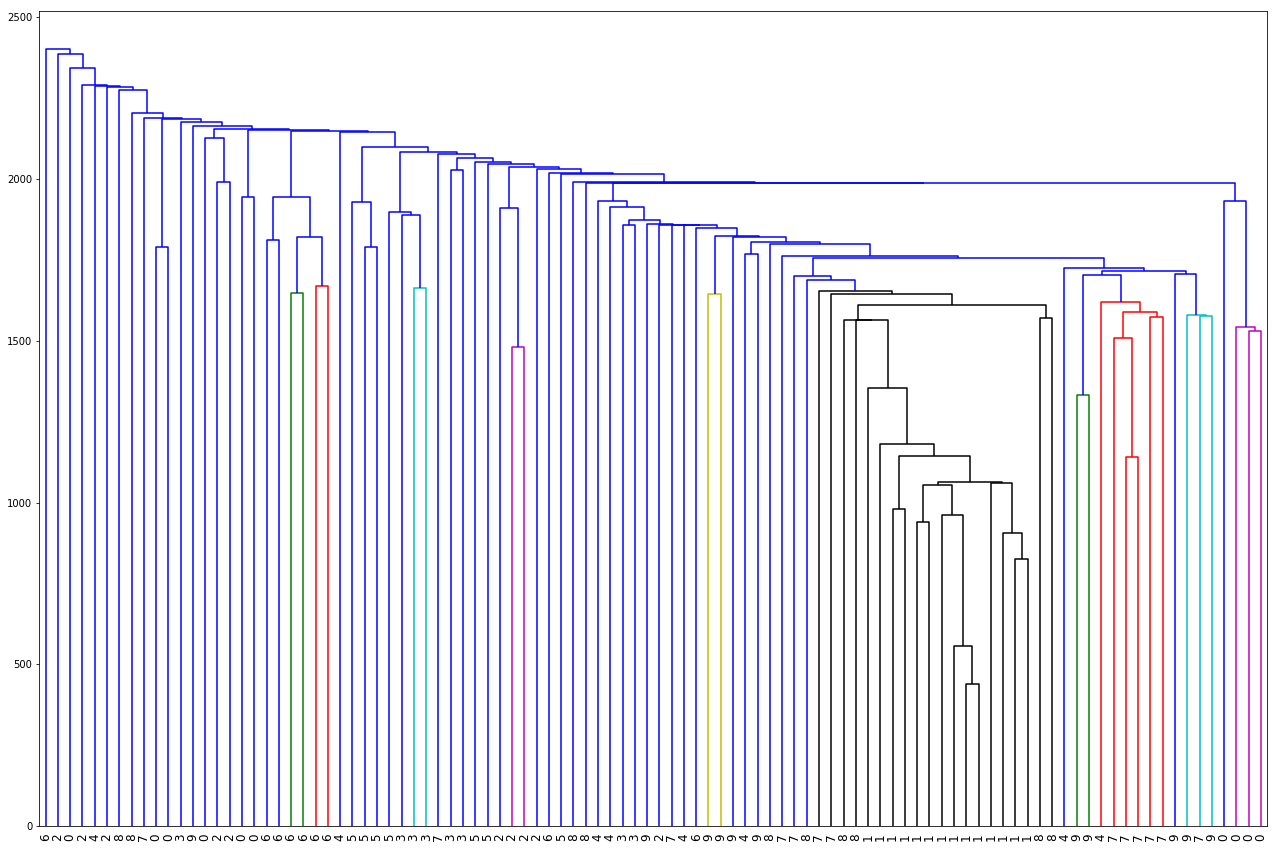

In [83]:
Z = linkage(train_img[rows[:n_select]], 'single')
plt.figure(figsize=(22, 15))
_ = dendrogram(Z,labels = train_lbl[rows[:n_select]].astype('int'),leaf_font_size = 12)
# print(train_lbl[rows[:n_select]])

In [ ]:
#acknowlegements
